## Functional annotation of MAGs against Pcyc

This notebook is part of the analysis of the MAGs. 

## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Diamond, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge diamond pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```

### Sanity check

In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
bash --version | head -n 1

diamond version 2.1.8
1.1.5
3.3.4
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

The input is the fasta file with contigs and the count table. 

In [3]:
fasta_file = "../data/mags.fasta"
count_table = "../data/mags.tsv"
## Sanity check: fasta and count table exit
assert os.path.exists(fasta_file), "Fasta file does not exist"
assert os.path.exists(count_table), "Count table does not exist"

In [4]:
%%bash -s "$fasta_file"
grep -c '>' < $1

87755


### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = '../results/PCycDB_mags_matches.tsv'

## Run Diamond 

In [6]:
database = '/data_2/Databases/PCycDB/release_v1.1/PCycDBv1.1.dmnd'
fasta = '/data_2/Databases/PCycDB/release_v1.1/PCycDBv1.1.faa'
annotation_file = '/data_2/Databases/PCycDB/release_v1.1/id2genemap.txt'
assert os.path.exists(annotation_file), 'Annotation file does not exist'
assert os.path.exists(fasta), 'Fasta file does not exist'
assert os.path.exists(database), 'Database file does not exist'

In [7]:
%%bash
mkdir -p ../results/

**Please, be aware that, without using any sensitivity option, the default mode is designed for finding hits of >60% identity. Consider increasing the sensitivity (or decreasing it).**

In [8]:
%%bash -s "$database" "$fasta_file" "$outfile_matches"
if [ ! -f $3 ]; then
diamond blastx -p 50 -d $1 -q $2 -o $3
fi
head $3

bin_1.fasta_00001	467200.ACFA01000617_gene1146	27.4	277	197	2	280	1107	266	539	3.81e-16	84.3
bin_1.fasta_00001	1229780.BN381_130287	43.4	76	42	1	25	252	198	272	1.52e-12	71.6
bin_1.fasta_00001	1121381.JNIV01000001_gene2891	45.3	64	35	0	28	219	174	237	3.64e-08	58.2
bin_1.fasta_00001	888056.HMPREF9062_0606	40.9	66	38	1	46	240	186	251	4.11e-08	58.2
bin_1.fasta_00001	1125863.JAFN01000001_gene2598	40.3	67	38	1	40	234	200	266	1.13e-07	57.0
bin_1.fasta_00001	1317118.ATO8_11674	39.1	69	41	1	16	219	177	245	1.06e-06	53.9
bin_1.fasta_00001	37919.EP51_38565	46.4	56	29	1	31	195	220	275	1.87e-06	53.5
bin_1.fasta_00001	roa:Pd630_LPD04970	46.4	56	29	1	31	195	222	277	1.89e-06	53.5
bin_1.fasta_00001	cart:PA27867_3301	43.8	80	38	3	1	219	209	288	1.92e-06	53.5
bin_1.fasta_00001	phh:AFB00_28750	47.3	55	29	0	13	177	186	240	2.45e-06	52.8


diamond v2.1.8.162 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 50
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: ../results
#Target sequences to report alignments for: 25
Opening the database...  [0.072s]
Database: /data_2/Databases/PCycDB/release_v1.1/PCycDBv1.1.dmnd (type: Diamond database, sequences: 1174934, letters: 403960101)
Block size = 2000000000
Algorithm: Double-indexed
Building query histograms...  [0.194s]
Seeking in database...  [0s]
Loading reference sequences...  [0.8s]
Masking reference...  [0.782s]
Initializing temporary storage...  [0s]
Building reference histograms...  [1.03s]
Allocating buffers...  [0.001s]
Processing query block 1, reference block 1/1, shape 1/2, index chunk 1/4.
Building refere

## Parse Diamond output and preprocess

In [9]:
diamond = pd.read_csv(
    outfile_matches,
    delimiter="\t",
    comment="#",
    header=None,
    names=[
        "Query id",
        "Subject id",
        "% identity",
        "alignment length",
        "mismatches",
        "gap openings",
        "q. start",
        "q. end",
        "s. start",
        "s. end",
        "e-value",
        "score",
    ],
)

Now, we have a table with all the alignments between our "genes" and the database.

In [10]:
diamond

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,bin_1.fasta_00001,467200.ACFA01000617_gene1146,27.4,277,197,2,280,1107,266,539,3.810000e-16,84.3
1,bin_1.fasta_00001,1229780.BN381_130287,43.4,76,42,1,25,252,198,272,1.520000e-12,71.6
2,bin_1.fasta_00001,1121381.JNIV01000001_gene2891,45.3,64,35,0,28,219,174,237,3.640000e-08,58.2
3,bin_1.fasta_00001,888056.HMPREF9062_0606,40.9,66,38,1,46,240,186,251,4.110000e-08,58.2
4,bin_1.fasta_00001,1125863.JAFN01000001_gene2598,40.3,67,38,1,40,234,200,266,1.130000e-07,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
298256,bin_8.fasta_03060,aol:S58_48060,52.2,46,21,1,283,420,11,55,3.820000e-08,52.4
298257,bin_8.fasta_03067,754035.Mesau_02816,42.5,40,23,0,80,199,177,216,6.680000e-04,41.2
298258,bin_8.fasta_03068,1298598.JCM21714_4640,59.0,39,16,0,162,46,1,39,4.890000e-09,52.4
298259,bin_8.fasta_03074,981336.F944_02633,40.5,37,22,0,7,117,6,42,4.010000e-04,38.9


## Read count table
However, we also need to read the count table:

In [11]:
%%bash -s "$count_table"
head $1

ContigID	ika_mgs_val_2	ika_mgs_val_1
bin_37.fasta_02940	31	30
bin_36.fasta_03910	123	129
bin_11.fasta_01027	88	97
bin_1.fasta_02543	25	21
bin_71.fasta_02748	93	92
bin_3.fasta_02341	43	47
bin_38.fasta_03427	12	13
bin_41.fasta_00268	13	8
bin_24.fasta_00934	23	21


In [12]:
counts = pd.read_csv(count_table, sep="\t", comment="#").set_index("ContigID")
# Check that there are only 2 columns
assert counts.shape[1] == 2, "Count table should have 2 columns"
# Sum the counts for each MAG
counts = counts.sum(axis=1)
# Convert to a dataframe
counts = pd.DataFrame(counts, columns=["Count"])
counts

,Count
ContigID,
bin_37.fasta_02940,61
bin_36.fasta_03910,252
bin_11.fasta_01027,185
bin_1.fasta_02543,46
bin_71.fasta_02748,185
...,...
bin_61.fasta_00597,47
bin_36.fasta_03334,395
bin_37.fasta_02681,53


## Preprocessing
### Most significant hit per Contig

Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

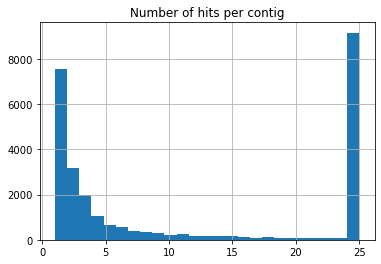

In [13]:
diamond.pivot_table(columns=["Query id"], aggfunc="size").hist(bins=25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [14]:
diamond = (
    diamond.sort_values(by=["e-value", "score"], ascending=[True, False])
    .drop_duplicates("Query id", keep="first")
    .set_index("Query id")
)
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
bin_2.fasta_00970,A0A259F5K2,97.8,1317,29,0,1,3951,1,1317,0.000000,2556.0
bin_33.fasta_02347,A0A6I7N538,95.1,1294,63,0,1,3882,1,1294,0.000000,2431.0
bin_3.fasta_02645,472759.Nhal_0647,70.2,1700,479,6,49,5088,3,1695,0.000000,2355.0
bin_37.fasta_03545,713586.KB900536_gene2776,83.6,1334,214,3,37,4032,13,1343,0.000000,2244.0
bin_30.fasta_02039,rbg:BG454_03510,91.0,1215,109,0,1,3645,1,1215,0.000000,2239.0
...,...,...,...,...,...,...,...,...,...,...,...
bin_39.fasta_01109,433637671,26.0,177,110,6,442,936,12,179,0.000979,45.4
bin_38.fasta_00505,1173023.KE650771_gene2306,24.6,224,145,9,160,807,704,911,0.000983,46.6
bin_32.fasta_02671,1385935.N836_22455,45.5,44,21,1,160,282,1,44,0.000989,40.0


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<AxesSubplot:title={'center':'e-value'}>]], dtype=object)

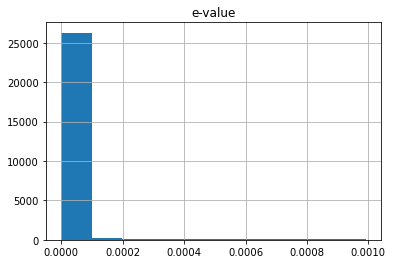

In [15]:
diamond.hist("e-value")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

In [16]:
evalue_threshold = 0.0001

In [17]:
diamond = diamond.loc[diamond["e-value"] < evalue_threshold]

array([[<AxesSubplot:title={'center':'e-value'}>]], dtype=object)

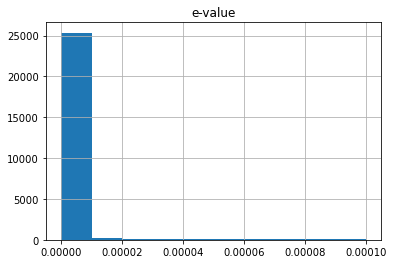

In [18]:
diamond.hist("e-value")

In [19]:
val = len(set(diamond["Subject id"]))
print(f"There are {val} unique orthologous genes")

There are 10767 unique orthologous genes


### Inspect % identity and aligment length

array([[<AxesSubplot:title={'center':'alignment length'}>]], dtype=object)

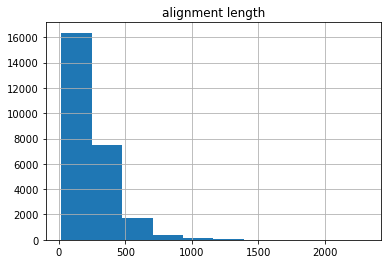

In [20]:
diamond.hist("alignment length")

array([[<AxesSubplot:title={'center':'% identity'}>]], dtype=object)

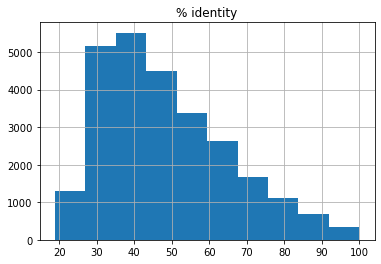

In [21]:
diamond.hist("% identity")

In [22]:
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
bin_2.fasta_00970,A0A259F5K2,97.8,1317,29,0,1,3951,1,1317,0.000000,2556.0
bin_33.fasta_02347,A0A6I7N538,95.1,1294,63,0,1,3882,1,1294,0.000000,2431.0
bin_3.fasta_02645,472759.Nhal_0647,70.2,1700,479,6,49,5088,3,1695,0.000000,2355.0
bin_37.fasta_03545,713586.KB900536_gene2776,83.6,1334,214,3,37,4032,13,1343,0.000000,2244.0
bin_30.fasta_02039,rbg:BG454_03510,91.0,1215,109,0,1,3645,1,1215,0.000000,2239.0
...,...,...,...,...,...,...,...,...,...,...,...
bin_3.fasta_03310,9315.ENSMEUP00000003337,27.7,195,127,5,1,555,705,895,0.000099,49.7
bin_1.fasta_02384,227086.JGI_V11_79883,36.8,76,35,1,7,195,89,164,0.000099,45.8
bin_37.fasta_03002,1048339.KB913029_gene226,34.0,53,35,0,952,1110,1,53,0.000100,43.9


Text(0, 0.5, 'Mistmatches')

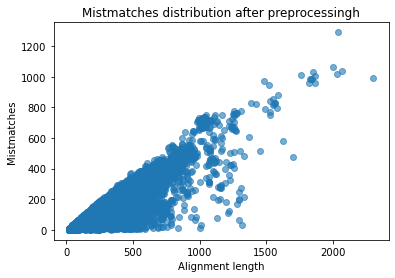

In [23]:
plt.scatter(diamond["alignment length"], diamond.mismatches, alpha=0.6)
plt.title("Mistmatches distribution after preprocessingh")
plt.xlabel("Alignment length")
plt.ylabel("Mistmatches")

## Attention !!
Please, consider the previous information to set the threshold for the e-value and the % identity.

### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table). 

In [24]:
map_table = diamond[["Subject id"]]
map_table

,Subject id
Query id,
bin_2.fasta_00970,A0A259F5K2
bin_33.fasta_02347,A0A6I7N538
bin_3.fasta_02645,472759.Nhal_0647
bin_37.fasta_03545,713586.KB900536_gene2776
bin_30.fasta_02039,rbg:BG454_03510
...,...
bin_3.fasta_03310,9315.ENSMEUP00000003337
bin_1.fasta_02384,227086.JGI_V11_79883
bin_37.fasta_03002,1048339.KB913029_gene226


Now, we create an extra column with the bin name.

In [25]:
# Get everything before first '.'
map_table['bin'] = map_table.index.str.split(".").str[0] 
map_table

/software/anaconda3/envs/jupyter-diamond/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Subject id,bin
Query id,,
bin_2.fasta_00970,A0A259F5K2,bin_2
bin_33.fasta_02347,A0A6I7N538,bin_33
bin_3.fasta_02645,472759.Nhal_0647,bin_3
bin_37.fasta_03545,713586.KB900536_gene2776,bin_37
bin_30.fasta_02039,rbg:BG454_03510,bin_30
...,...,...
bin_3.fasta_03310,9315.ENSMEUP00000003337,bin_3
bin_1.fasta_02384,227086.JGI_V11_79883,bin_1
bin_37.fasta_03002,1048339.KB913029_gene226,bin_37


Now, we are going to merge both files by their column in common (ContigID and Subject id).

In [26]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
    drop=True
)
df

,Subject id,bin,Count
0,A0A259F5K2,bin_2,664
1,A0A6I7N538,bin_33,1487
2,472759.Nhal_0647,bin_3,302
3,713586.KB900536_gene2776,bin_37,285
4,rbg:BG454_03510,bin_30,471
...,...,...,...
26262,9315.ENSMEUP00000003337,bin_3,91
26263,227086.JGI_V11_79883,bin_1,45
26264,1048339.KB913029_gene226,bin_37,103
26265,1094184.KWO_0117050,bin_10,20


Finally, we are going to make the table wider (from long format to wide format) and fill the empty values with 0. 

In [27]:
df_transformed = df.pivot_table(index='Subject id', columns='bin', values='Count', fill_value=0, aggfunc='sum')
df_transformed.reset_index(inplace=True)
df_transformed.columns.name = None
# Arrange columns so Subject id is first, then sort
df_transformed = df_transformed[["Subject id"] + sorted(df_transformed.columns[1:])]
df_transformed


,Subject id,bin_1,bin_10,bin_11,bin_16,bin_17,bin_2,bin_24,bin_26,bin_27,...,bin_38,bin_39,bin_41,bin_48,bin_52,bin_61,bin_65,bin_68,bin_71,bin_8
0,1000565.METUNv1_00075,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000565.METUNv1_00256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000565.METUNv1_01616,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
3,1000565.METUNv1_04027,0,0,0,0,0,72,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1001585.MDS_2194,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10762,ypp:YPDSF_0314,0,0,0,0,0,44,29,0,0,...,0,0,0,0,0,0,0,0,0,54
10763,zdf:AN401_09490,0,0,0,0,0,50,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,zdf:AN401_14975,0,0,0,0,0,29,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,zpa:C3497_13650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66


## Annotating count table

Now, we have to annotate the table. Let's extract that info from the fasta header. See (this issue)[https://github.com/ZengJiaxiong/Phosphorus-cycling-database/issues/11] for more information.

In [28]:
%%bash -s "$fasta"
grep '>' < $1 | \
    # Change sequences following other format
    # This is the case of the sequences that have [gene=adk,souce=NCBI_archaea_refseq]
    sed 's/,souce/ ontology=unknown source/g' | \
    # Change case where there are spaces instead of _ such as'ADE2 homolog' to 'ADE2_homolog'
    sed 's/ homolog/_homolog/g' | \
    sed 's/gene=/description=/g' | \
    # Remove the '>' from the beginning of each line
    sed 's/>//g' | \
    # Remove []
    sed 's/\[//g' | sed 's/\]//g' | \
    # Remove 'description=', 'ontology=' and 'source='
    sed 's/description=//g' | sed 's/ontology=//g' | sed 's/source=//g' | sed 's/gene=//g' | \
    # Substitute spaces with ,
    sed 's/ /,/g' > id2gene_PCycDB.csv

In [29]:
annotations = pd.read_csv(
    'id2gene_PCycDB.csv',header=None, engine='python',
    names = ['name', 'gene', 'ontology', 'source']
    )
annotations

,name,gene,ontology,source
0,161934.XP_010688184.1,ADE2,COG0152,eggNOG
1,159749.K0RBF6,ADE2,COG0152,eggNOG
2,192875.XP_004363538.1,ADE2,COG0152,eggNOG
3,296587.XP_002506041.1,ADE2,COG0152,eggNOG
4,5297.GMQ_22454T0,ADE2,COG0152,eggNOG
...,...,...,...,...
1174929,55207.KP22_11735,lysR,COG0583,eggNOG
1174930,359.CN09_32225,lysR,COG0583,eggNOG
1174931,399741.Spro_1535,lysR,COG0583,eggNOG
1174932,642227.HA49_06910,lysR,COG0583,eggNOG


Now, we merge both tables by their column in common (Subject id and orthologous genes header)

In [30]:
df_transformed = df_transformed.merge(
    annotations, left_on='Subject id',
    right_on='name', how = 'left'
    ).set_index('name')

The database includes non-phosphorus genes (to reduce the number of false positives). Those entries either have no annotation, or have the keyword "homologous". We are going to remove them from the table:

In [31]:
# Remove rows with NA
df_transformed.dropna(inplace=True)
# Remove rows with keyword 'homologous'
df_transformed = df_transformed[~df_transformed['gene'].str.contains('homolog')]
df_transformed

,Subject id,bin_1,bin_10,bin_11,bin_16,bin_17,bin_2,bin_24,bin_26,bin_27,...,bin_48,bin_52,bin_61,bin_65,bin_68,bin_71,bin_8,gene,ontology,source
name,,,,,,,,,,,,,,,,,,,,,
1000565.METUNv1_00075,1000565.METUNv1_00075,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,phoP,COG0745,eggNOG
1000565.METUNv1_00256,1000565.METUNv1_00256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,phoB,COG0745,eggNOG
1002340.AFCF01000065_gene90,1002340.AFCF01000065_gene90,0,0,0,0,0,144,0,0,0,...,0,0,0,517,0,0,0,pbfA,COG0160,eggNOG
1004149.AFOE01000017_gene799,1004149.AFOE01000017_gene799,0,0,0,0,107,0,0,82,0,...,0,0,101,0,0,0,0,gntK,COG3265,eggNOG
1007103.AFHW01000092_gene3643,1007103.AFHW01000092_gene3643,0,0,0,0,0,0,0,0,0,...,60,0,0,0,0,0,0,phnPP,COG0613,eggNOG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wcf:C6P13_01660,wcf:C6P13_01660,0,0,301,0,0,0,0,0,0,...,0,0,0,0,0,0,0,rtpR,K00527,KEGG
wma:WM2015_1724,wma:WM2015_1724,0,0,0,0,0,0,46,0,0,...,0,0,0,0,0,0,0,ppa,K01507,KEGG
woc:BA177_08940,woc:BA177_08940,0,0,0,0,0,0,52,0,0,...,0,0,0,0,0,0,0,phoP,K07660,KEGG


In [32]:
# Comment this to have one hit per row, rather than one "annotation" per row
df_transformed = df_transformed.groupby('gene').sum().reset_index()
df_transformed

,gene,bin_1,bin_10,bin_11,bin_16,bin_17,bin_2,bin_24,bin_26,bin_27,...,bin_38,bin_39,bin_41,bin_48,bin_52,bin_61,bin_65,bin_68,bin_71,bin_8
0,ADE2,0,0,0,0,96,0,0,104,293,...,0,0,64,80,0,119,0,0,125,0
1,RegX3,330,0,0,45,252,431,256,142,0,...,132,0,0,123,285,535,1169,0,266,54
2,SenX3,154,0,140,0,346,0,0,0,377,...,15,88,0,106,0,89,0,315,572,0
3,adk,0,214,487,835,255,134,84,292,524,...,207,37,63,576,362,321,0,736,1202,307
4,cmk,844,491,728,396,387,419,780,531,1381,...,192,202,172,551,475,388,1344,997,533,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,ugpB,213,0,0,163,0,68,0,56,0,...,55,0,0,0,0,0,449,0,743,57
110,ugpC,0,317,130,969,83,309,224,296,742,...,0,136,139,61,169,409,1192,263,3835,421
111,ugpE,64,56,214,0,0,0,0,0,0,...,0,0,0,67,42,0,575,0,679,0
112,ugpQ,0,0,0,0,0,0,76,0,0,...,0,0,37,0,0,0,0,0,87,0


Finally, we save the table and remove the temporary files:

In [33]:
df_transformed.to_csv('../results/PCycDB_mags_matches_annotated.tsv', sep='\t', index=False)

In [34]:
%%bash
rm id2gene_PCycDB.csv